In [3]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import BertTokenizer, BertModel
# from transformers import AutoTokenizer, AutoModel

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Parameters
batch_size = 64
num_epochs = 5
num_samples = 10
learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size

In [5]:
# load the "irony" dataset(name=irony)
cache_dir = "./data_cache_"
subset_name = "irony"

train_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_)} instances loaded")

val_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_)} instances loaded")

test_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_)} instances loaded")

num_classes_ = np.unique(train_dataset_['label']).size

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to ./data_cache_/tweet_eval/irony/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.
Training dataset with 2862 instances loaded


Validation dataset with 955 instances loaded


Test dataset with 784 instances loaded


In [6]:
# create Tokenizer object
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# create 'input_ids', 'token_type_ids', 'attention_mask' for train/val/test dataset
def tokenize_function(dataset):
    model_inputs = tokenizer(dataset['text'], padding="max_length", max_length=100, truncation=True)
    return model_inputs

train_dataset_ = train_dataset_.map(tokenize_function, batched=True)
val_dataset_ = val_dataset_.map(tokenize_function, batched=True)
test_dataset_ = test_dataset_.map(tokenize_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [7]:
# convert dataset to dataloader
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    # 'attention_mask' is also taken into consideration when constructing DataLoader(def forward())
    atten_tensor = torch.from_numpy(np.array(dataset['attention_mask']))
    
    tensor_dataset = TensorDataset(input_tensor, atten_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

# get all sentences ready for the model
train_loader = convert_to_data_loader(train_dataset_, num_classes_)
val_loader = convert_to_data_loader(val_dataset_, num_classes_)
test_loader = convert_to_data_loader(test_dataset_, num_classes_)

Build the model

In [8]:
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert, aleatoric_use, num_labels):
        super(BertClassifier, self).__init__()

        # use the pretrained bert model corresponding to the previous tokenizer
        self.aleatoric_use = aleatoric_use
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        # self.bert = BertModel.from_pretrained("robert-base")
        self.config = self.bert.config
        """
        "_name_or_path": "roberta-base",
        "architectures": ["RobertaForMaskedLM"],
        "attention_probs_dropout_prob": 0.1,
        "bos_token_id": 0,
        "classifier_dropout": null,
        "eos_token_id": 2,
        "hidden_act": "gelu",
        "hidden_dropout_prob": 0.1,
        "hidden_size": 768,
        "initializer_range": 0.02,
        "intermediate_size": 3072,
        "layer_norm_eps": 1e-05,
        "max_position_embeddings": 514,
        "model_type": "roberta",
        "num_attention_heads": 12,
        "num_hidden_layers": 12,
        "pad_token_id": 1,
        "position_embedding_type": "absolute",
        "transformers_version": "4.21.0",
        "type_vocab_size": 1,
        "use_cache": true,
        "vocab_size": 50265
        """
        # specify the parameter for the classifier
        n_input = self.config.hidden_size
        n_hidden = 50
        p_ = 0.2

        # add dense layers to act as the classifier
        self.classifier = nn.Linear(n_input, n_hidden)

        self.predict = torch.nn.Linear(n_hidden, num_labels)   # predicted output
        self.get_var = torch.nn.Linear(n_hidden, num_labels)   # predicted variance

        # execute when freeze_bert=True
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        else:
            for param in self.bert.parameters():
                param.requires_grad = True
    
    def forward(self, input_ids, attention_mask):
        # get the outputs of the roberta model
        bert_outputs = self.bert(input_ids=input_ids,attention_mask=attention_mask)

        # extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_outputs = bert_outputs[0][:,0,:]

        # Feed input to classifier to compute results(one number for each class)
        x = last_hidden_state_outputs  # 64*768
        x = self.classifier(x)  # 64*50
        x = F.relu(x)  # 64*50
        x = F.dropout(x, p=0.2)  # 64*50
        
        logits = self.predict(x)  # logits layer 64*2
        if self.aleatoric_use:  # consider aleatoric uncertainty --> two sets of output
          sigma = self.get_var(x)  # uncertainty layer 64*2
          return logits, sigma
        else:
          return logits

In [9]:
# model combined uncertainty
model_comb = BertClassifier(freeze_bert=True, aleatoric_use=True, num_labels=num_classes_)
model_comb

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
# import torch
# predict = torch.tensor([[1,2],[2,5],[11,10],[15,12]])
# true = torch.tensor([0,1,1,0])
# label = [0,1]
# label = torch.tensor(label)
# label_pro = [[0]*num_classes_ for _ in range(true.size(0))]
# for num, i in enumerate(true.data.numpy()):
#   label_pro[num][i] = 1
# print(label_pro)

In [10]:
def combined_loss_function(labels, x_i):
  golden_labels = labels.view(-1,1)
  y_hat = torch.zeros(labels.size(0), num_classes_)  # 64*2
  # In the direction of dimension 1 (rows, 2 rows in total), fill in 1 with golden_labels as subscript
  y_hat = y_hat.scatter(1, golden_labels, 1)

  y_i = torch.zeros((num_samples, labels.size(0), num_classes_)) # 10*64*2

  for t in range(num_samples):
    y_i[t] = y_hat

  # start computing loss
  loss0 = torch.log(torch.sum(torch.exp(x_i),dim=2))
            
  x_itc_hat = torch.sum(x_i*y_i,dim=2)
  loss1 = torch.mean(torch.exp(x_itc_hat-loss0),dim=0)

  loss = torch.sum(-torch.log(loss1))
  return loss

In [11]:
def apply_dropout(m):
  if type(m) == F.dropout:  # type(m) == nn.Dropout or
    m.train()

# net.eval()
# net.apply(apply_dropout)

In [12]:
def train_combined(num_epochs, model, train_dataloader, dev_dataloader):  

    loss_fn = combined_loss_function  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
    
    # Store the data for plotting
    X = []
    train_losses_set = []
    train_accuracy_set = []
    dev_losses_set = []
    dev_accuracy_set = []
    
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []

        model.train()  # Put the model in training mode.

        # batch_atten(atten_mask) is also used to compute the model output
        for i, (batch_input_ids, batch_atten, batch_labels) in enumerate(train_dataloader):

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            mu, sigma = model(batch_input_ids, batch_atten) # 64*2

            prob_total = torch.zeros((num_samples, batch_labels.size(0), num_classes_)) # 10*64*2
            x_i = torch.zeros((num_samples, batch_labels.size(0), num_classes_)) # 10*64*2
            for t in range(num_samples):
              epsilon = torch.randn(sigma.size())  # 64*2
              logit = mu + torch.mul(sigma, epsilon)  # 64*2
              x_i[t] = logit
              prob_total[t] = F.softmax(logit, dim=1) # 64*2 into probability
            prob_ave = torch.mean(prob_total, 0) # compute the mean of the 10 64*2 matrices

            # Compute the loss for the current batch of data 
            batch_loss = loss_fn(batch_labels, x_i)
            print("my batch_loss:{}".format(batch_loss))

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())

            # Count correct labels so we can compute accuracy on the training set
            pred_y = torch.max(prob_ave, 1)[1].data.numpy()
            total_correct += (pred_y == batch_labels.data.numpy()).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))
        
        X.append(e+1)
        train_losses_set.append(np.mean(train_losses))
        train_accuracy_set.append(train_accuracy)

        model.eval()  # Switch model to evaluation mode
        model.apply(apply_dropout) # Keep the dropout layer open when testing
        
        total_correct = 0
        total_trained = 0
        dev_losses = []

        for dev_input_ids, dev_atten, dev_labels in dev_dataloader:

            # Use the model to performance forward inference on the development data
            dev_mu, dev_sigma = model(dev_input_ids, dev_atten)
            
            dev_prob_total = torch.zeros((num_samples, dev_labels.size(0), num_classes_))
            dev_x_i = torch.zeros((num_samples, dev_labels.size(0), num_classes_))
            for t in range(num_samples):
              epsilon = torch.randn(dev_sigma.size())
              logit = dev_mu + torch.mul(dev_sigma, epsilon)
              dev_x_i[t] = logit
              dev_prob_total[t] = F.softmax(logit, dim=1)
            dev_prob_ave = torch.mean(dev_prob_total, 0)

            # Compute the loss for the development data
            dev_loss = loss_fn(dev_labels, dev_x_i) # dev_loss computed by my loss_function

            # Save the loss on the dev set
            dev_losses.append(dev_loss.item())

            # Count the number of correct predictions
            dev_output_y = torch.max(dev_prob_ave, 1)[1].data.numpy()
            # predicted_labels = dev_output_y.argmax(1)
            total_correct += (dev_output_y == dev_labels.data.numpy()).sum().item()
            total_trained += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_trained*100
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))
        
        dev_losses_set.append(np.mean(dev_losses))
        dev_accuracy_set.append(dev_accuracy)
    
    # Plotting to show the accuracy and loss
    plt.figure()
    plt.plot(X,train_accuracy_set,'ob--',label='Train Accuracy')
    plt.plot(X,dev_accuracy_set,'or--',label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy(%)')
    
    plt.figure()
    plt.plot(X,train_losses_set,'ob--',label='Train Loss')
    plt.plot(X,dev_losses_set,'or--',label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')

    # plt.figure()
    # plt.plot(X,train_uncertainty_set,'ob--',label='Train Loss')
    # plt.plot(X,dev_uncertainty_set,'or--',label='Validation Loss')
    # plt.legend()
    # plt.xlabel('Number of epochs')
    # plt.ylabel('Combined Uncertainty')
    
    return model

Train and validate

my batch_loss:45.06473159790039
my batch_loss:44.858089447021484
my batch_loss:44.83182144165039
my batch_loss:43.450347900390625
my batch_loss:44.653175354003906
my batch_loss:44.627418518066406
my batch_loss:43.56208801269531
my batch_loss:45.206512451171875
my batch_loss:42.373741149902344
my batch_loss:43.075626373291016
my batch_loss:43.572750091552734
my batch_loss:44.7907829284668
my batch_loss:42.80118942260742
my batch_loss:44.174808502197266
my batch_loss:44.282066345214844
my batch_loss:43.28242492675781
my batch_loss:43.171356201171875
my batch_loss:42.959625244140625
my batch_loss:43.33277130126953
my batch_loss:42.760009765625
my batch_loss:41.043739318847656
my batch_loss:43.801570892333984
my batch_loss:46.022396087646484
my batch_loss:47.86662673950195
my batch_loss:48.08548355102539
my batch_loss:43.22416305541992
my batch_loss:44.5814094543457
my batch_loss:43.26857376098633
my batch_loss:40.80392837524414
my batch_loss:43.170310974121094
my batch_loss:43.86352157592

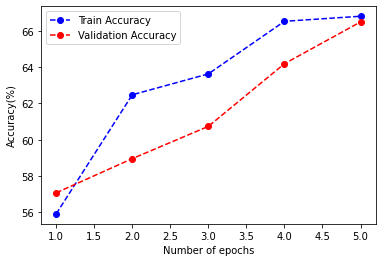

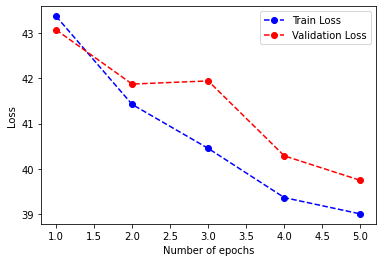

In [13]:
# model combined uncertainty
trained_model = train_combined(num_epochs=num_epochs, model=model_comb, train_dataloader=train_loader, dev_dataloader=val_loader)

predict on the test dataset

In [14]:
def predict_nn(trained_model, test_loader):

    trained_model.eval()

    correct = 0  # count the number of correct classification labels

    gold_labs = []  # gold labels to return
    pred_labs = []  # predicted labels to return
    
    for inputs, atten, labels in test_loader:
        test_mu, test_sigma = trained_model(inputs, atten)
        # take the label with biggest output as the predicted label
        predicted_labels = test_mu.argmax(1)

        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    
    return gold_labs, pred_labs

In [15]:
gold_labs, pred_labs = predict_nn(trained_model, test_loader)

# classification report
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = ['irony', 'not irony']
print("The classification report is:")
print(classification_report(gold_labs, pred_labs,target_names=target_names))

# confusion matrix
cm = confusion_matrix(gold_labs, pred_labs)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
print("The confusion matrix is:")
print(df_cm)

The classification report is:
              precision    recall  f1-score   support

       irony       0.73      0.63      0.67       473
   not irony       0.53      0.64      0.58       311

    accuracy                           0.63       784
   macro avg       0.63      0.63      0.63       784
weighted avg       0.65      0.63      0.64       784

The confusion matrix is:
           irony  not irony
irony        298        175
not irony    112        199


In [16]:
from sklearn.metrics import f1_score
f1_score(gold_labs, pred_labs, average='macro')

0.6279967926197187

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(gold_labs, pred_labs)

0.6339285714285714